# Проверка системы сплитования

Что нужно сделать: у нас есть данные А/А-теста с '2023-09-21' по '2023-09-27'. Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом

**1. Провести симуляцию А/А-теста и проверить результаты t-тестом**

In [3]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.stats import kstest

%matplotlib inline

In [4]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20231020',
              'user':'student',
              'password':'dpo_python_2020'
             }

In [5]:
quest = """SELECT exp_group, 
                user_id,
                SUM(action = 'like') as likes,
                SUM(action = 'view') as views,
                likes/views as ctr
            FROM 
                simulator_20231020.feed_actions
            WHERE 
                toDate(time) BETWEEN '2023-09-21' AND '2023-09-27'
                AND exp_group in (2, 3)
            GROUP BY 
                exp_group, 
                user_id
            """

df = ph.read_clickhouse(quest, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


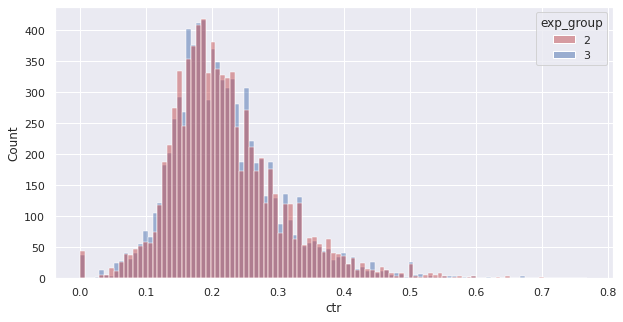

In [4]:
# Посмотрим на распределение двух экспериментальных групп

sns.set(rc={'figure.figsize':(10, 5)})

groups = sns.histplot(data = df, 
                      x='ctr', 
                      hue='exp_group', 
                      palette = ['r', 'b'],
                      alpha=0.5,
                      kde=False)

In [6]:
# Функция для симуляции А/А-тестов

def aa_simulation(group_1, group_2):
    simulation_group_1 = 0
    simulation_group_2 = 0
    p_values = []
    for _ in range(10000):
        simulation_group_1 = group_1.sample(500, replace=False)
        simulation_group_2 = group_2.sample(500, replace=False)
        p_values.append(stats.ttest_ind(simulation_group_1, simulation_group_2, equal_var=False)[1])
    print(f'Симуляция завершена. Рассчитано {len(p_values)} значений p-values')
    return p_values

In [7]:
group_2 = df.query('exp_group == 2').ctr
group_3 = df.query('exp_group == 3').ctr

In [12]:
# Проведем симуляцию 10000 А/А-тестов (для нормальных распределений)

simulation_p_values = aa_simulation(group_2, 
                                    group_3)

Симуляция завершена. Рассчитано 10000 значений p-values


**2. Построить гистограмму распределения получившихся 10000 p-values.**

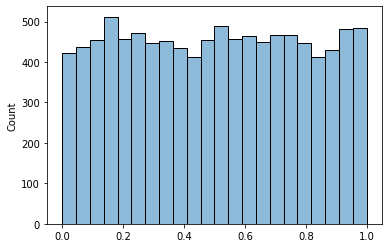

In [13]:
groups_test = sns.histplot(data=simulation_p_values,
                           alpha=0.5,
                           kde=False)

In [10]:
# Проверяем является ли распределение p-values равномерным

def check_uniform_distribution(values):
    result = kstest(values, 'uniform')
    if result[1] < 0.05:
        print("Гипотеза о равномерности распределения отвергается")
    else:
        print("Гипотеза о равномерности распределения не отвергается")

In [14]:
check_uniform_distribution(simulation_p_values)

Гипотеза о равномерности распределения не отвергается


**3. Посчитать, какой процент p-values оказался меньше либо равен 0.05**

In [15]:
def determine_percentage(list_p_values):
    check_p_values = []
    for i in list_p_values:
        if i <= 0.05:
            check_p_values.append(1)
        else:
            check_p_values.append(0)
    
    df_for_p_values = pd.DataFrame({'binary_p_value': check_p_values}).reset_index()
    persentage = df_for_p_values.groupby('binary_p_value').index.count().iloc[1] * 0.01
    return persentage

In [16]:
determine_percentage(simulation_p_values)

4.57

**4. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.**

Цель анализа: проверить корректность работы системы сплитования. Работу системы будем считать корректной тогда, когда при проведении А/А-тестов у нас не возникает статистически значимых различий по ключевой метрике между группами.

Проверка производилась на основе рассчитаного показателя CTR за период с '2023-09-21' по '2023-09-27' на 2 и 3 экспрериментальных группах. Была произведена симуляция 10000 А/А-тестов, в ходе которой из каждой экспериментальной группы многократно извлекалось по 500 пользователей (без повторения) и производилось их последующее сравнения с помощью t-критерия Стьюдента.

Построив гистограмму распределения получившихся p-values мы видим, что оно похоже на равномерное. Дополнительно убеждаемся в этом при помощи теста Колмогорова-Смирнова, который подтверждает наше предположение о равномерности распределения. 

Если наши p-values распределены равномерно, то это значит, что мы имеем одинаковую вероятность получить любое конкретное значение p-value для всех возможных значений. Если система сплитования работает случайным образом, то различные сплиты должны иметь одинаковую вероятность попадания в каждую из групп. Таким образом, равномерное распределение p-values подтверждает случайность и равномерность сплитования.

Процент получившихся p-values оказался равен 4,57%, т.е. примерно 5% ложноположительных результатов и равномерность распределения говорят нам о том, что система сплитовая работает корректно.